# Tutorial

> The goal of this challenge is to find all instances of dolphins in a picture and then color pixes of each dolphin with a unique color.

Please open this notebook in Colab to edit it and submit a solution:
    
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cro-ai-league/dolphins-recognition-challenge/blob/master/00_notebooks/DolphinsTutorial.ipynb)

In [ ]:
%load_ext autoreload
%autoreload 2

We need to change runtime to GPU to speed up training:

!["Change runtime"](images/change_runtime.png)

In [ ]:
err = !nvidia-smi
if "failed" in err[0]:
    raise Exception("Change runtime in menu to GPU (Runtime->Change runtime type->GPU)")
    
!nvidia-smi

Tue Jan  5 12:28:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   52C    P2    58W / 275W |   1147MiB / 11177MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Import `dolphins_recognition_challenge` library if it is already installed or install it if it is not. Please restart the runtime by clicking on the button bellow if it say so.

In [ ]:
try:
    import dolphins_recognition_challenge
except Exception:
    if "google.colab" in str(get_ipython()):
        print("Running on CoLab")
        !pip install dolphins-recognition-challenge

In [ ]:
import dolphins_recognition_challenge
import numpy as np
import PIL
from PIL import Image

import torch
import torchvision
import pandas as pd
import seaborn as sns

## Download data

We start by downloading and visualizing the dataset containing 200 photographs with one or more dolphins split into a training set containing 160 photographs and a validation set containing 40 photographs.

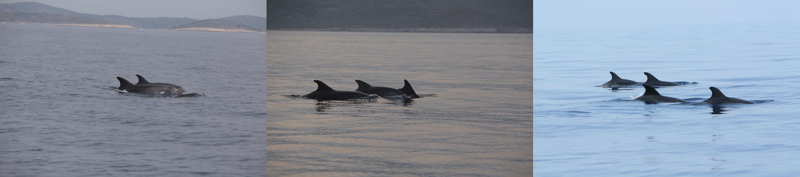

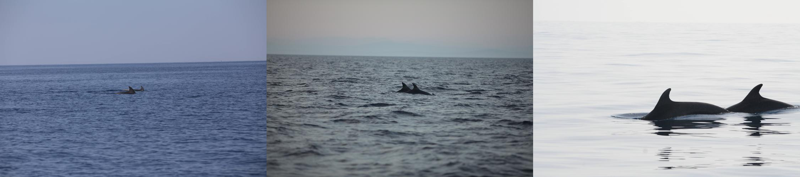

In [ ]:
from dolphins_recognition_challenge.datasets import get_dataset, display_batches
    
data_loader, data_loader_test = get_dataset("segmentation", batch_size=3)

display_batches(data_loader, n_batches=2)

## Data augmentation

In order to prevent overfitting which happens when the dataset size is too small, we perform a number of transformations to increase the size of the dataset. One transofrmation implemented in the Torch vision library is `RandomHorizontalFlip` and we will implemented `MyColorJitter` which is basically just a wrapper around `torchvision.transforms.ColorJitter` class. However, we cannot use this class directly without a wrapper because a transofrmation could possibly affect targets and not just the image. For example, if we were to implement RandomCrop, we would need to crop segmentation masks and readjust bounding boxes as well.

In [ ]:
class MyColorJitter:
    def __init__(self, brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5):
        self.torch_color_jitter = torchvision.transforms.ColorJitter(
            brightness=brightness, contrast=contrast, saturation=saturation, hue=hue
        )

    def __call__(self, image, target):
        image = self.torch_color_jitter(image)
        return image, target

We will make a series of transformations on an image and we will combine all those transofrmations in a single one as follows:

In [ ]:
from dolphins_recognition_challenge.datasets import ToTensor, ToPILImage, Compose, RandomHorizontalFlip

def get_tensor_transforms(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(
            MyColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
        )
        transforms.append(RandomHorizontalFlip(0.5))
        # TODO: add additional transforms: e.g. random crop
    return Compose(transforms)

With data augementation defined, we are ready to generate the actual datasets used for training our models.

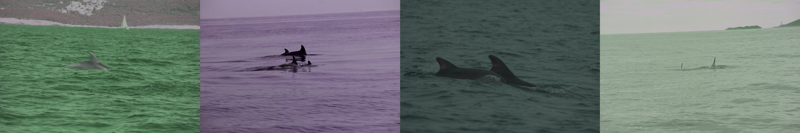

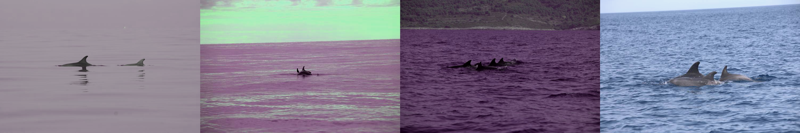

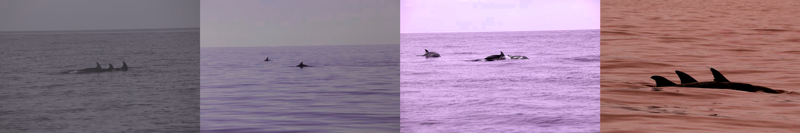

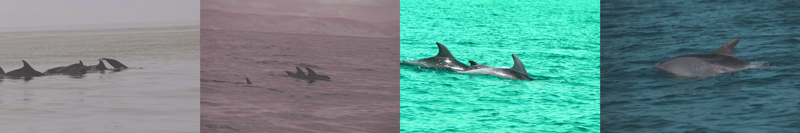

In [ ]:
batch_size = 4

data_loader, data_loader_test = get_dataset(
    "segmentation", get_tensor_transforms=get_tensor_transforms, batch_size=batch_size
)

display_batches(data_loader, n_batches=4)

> Tip: incorporate more transformation classes such as RandomCrop etc. (https://pytorch.org/docs/stable/torchvision/transforms.html)

## Model

We can reuse already trained models for instance segmentation trained on other dataset and finetune it for our particular problem, in our case on dataset with dolphins.

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_instance_segmentation_model(hidden_layer_size, box_score_thresh=0.5):
    # our dataset has two classes only - background and dolphin    
    num_classes = 2
    
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(
        pretrained=True, 
        box_score_thresh=box_score_thresh, 
    )

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_channels=in_features_mask, 
        dim_reduced=hidden_layer_size,
        num_classes=num_classes
    )

    return model

Before using a model constructed, we should move it to appropriate device. We will test if we have GPU available and move it to there if possible.

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# get the model using our helper function
model = get_instance_segmentation_model(hidden_layer_size=256)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

We have implemented a function for training a model for one epoch - meaning using each image from the training dataset exactly once. Let's train for one epochs an see what predictions we make before and after that.

In [ ]:
# used for automatic testing only
data_loader, data_loader_test = get_dataset(
    "segmentation",
    batch_size=4,
    get_tensor_transforms=get_tensor_transforms,
    n_samples=8,
)

In [ ]:
data_loader, data_loader_test = get_dataset(
    "segmentation", get_tensor_transforms=get_tensor_transforms, batch_size=batch_size
)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [ 0/40]  eta: 0:01:10  lr: 0.000133  loss: 5.4089 (5.4089)  loss_classifier: 0.6839 (0.6839)  loss_box_reg: 0.2898 (0.2898)  loss_mask: 4.4265 (4.4265)  loss_objectness: 0.0006 (0.0006)  loss_rpn_box_reg: 0.0080 (0.0080)  time: 1.7720  data: 0.9526  max mem: 4477
Epoch: [0]  [20/40]  eta: 0:00:15  lr: 0.002695  loss: 0.9911 (1.7665)  loss_classifier: 0.2020 (0.2973)  loss_box_reg: 0.2339 (0.2436)  loss_mask: 0.4659 (1.1417)  loss_objectness: 0.0188 (0.0392)  loss_rpn_box_reg: 0.0243 (0.0447)  time: 0.6990  data: 0.0148  max mem: 4757
Epoch: [0]  [39/40]  eta: 0:00:00  lr: 0.005000  loss: 0.6616 (1.2470)  loss_classifier: 0.1207 (0.2161)  loss_box_reg: 0.1964 (0.2248)  loss_mask: 0.2759 (0.7356)  loss_objectness: 0.0159 (0.0301)  loss_rpn_box_reg: 0.0159 (0.0402)  time: 0.6706  data: 0.0113  max mem: 5184
Epoch: [0] Total time: 0:00:28 (0.7132 s / it)
Epoch: [1]  [ 0/40]  eta: 0:01:08  lr: 0.005000  loss: 0.5226 (0.5226)  loss_classifier: 0.0928 (0.0928)  loss_box_reg: 0.179

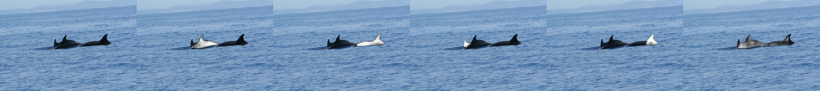

In [ ]:
from dolphins_recognition_challenge.instance_segmentation.model import train_one_epoch
from dolphins_recognition_challenge.instance_segmentation.model import show_predictions

show_predictions(model, data_loader=data_loader_test, n=1, score_threshold=0.5)

num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch=epoch, print_freq=20)

train_one_epoch(model, optimizer, data_loader, device, epoch=1, print_freq=20)

show_predictions(model, data_loader=data_loader_test, n=1, score_threshold=0.5)

Now we can fully train the model for more epochs, in this case for 20 more.

In [ ]:
num_epochs = 20

data_loader, data_loader_test = get_dataset(
    "segmentation", batch_size=4, get_tensor_transforms=get_tensor_transforms
)

In [ ]:
for epoch in range(1, num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch=epoch, print_freq=20)

    lr_scheduler.step()

Epoch: [1]  [ 0/40]  eta: 0:01:08  lr: 0.005000  loss: 0.5627 (0.5627)  loss_classifier: 0.0863 (0.0863)  loss_box_reg: 0.1434 (0.1434)  loss_mask: 0.2966 (0.2966)  loss_objectness: 0.0206 (0.0206)  loss_rpn_box_reg: 0.0158 (0.0158)  time: 1.7187  data: 0.9897  max mem: 5184
Epoch: [1]  [20/40]  eta: 0:00:14  lr: 0.005000  loss: 0.4207 (0.4558)  loss_classifier: 0.0734 (0.0762)  loss_box_reg: 0.1401 (0.1559)  loss_mask: 0.1883 (0.1992)  loss_objectness: 0.0054 (0.0072)  loss_rpn_box_reg: 0.0100 (0.0174)  time: 0.6977  data: 0.0109  max mem: 5184
Epoch: [1]  [39/40]  eta: 0:00:00  lr: 0.005000  loss: 0.4653 (0.4748)  loss_classifier: 0.0828 (0.0812)  loss_box_reg: 0.1526 (0.1589)  loss_mask: 0.1996 (0.2007)  loss_objectness: 0.0054 (0.0075)  loss_rpn_box_reg: 0.0091 (0.0265)  time: 0.6904  data: 0.0115  max mem: 5186
Epoch: [1] Total time: 0:00:28 (0.7205 s / it)
Epoch: [2]  [ 0/40]  eta: 0:01:10  lr: 0.005000  loss: 0.4450 (0.4450)  loss_classifier: 0.0741 (0.0741)  loss_box_reg: 0.148

Epoch: [10]  [39/40]  eta: 0:00:00  lr: 0.005000  loss: 0.2724 (0.2910)  loss_classifier: 0.0395 (0.0425)  loss_box_reg: 0.0846 (0.0938)  loss_mask: 0.1331 (0.1350)  loss_objectness: 0.0023 (0.0072)  loss_rpn_box_reg: 0.0052 (0.0125)  time: 0.7079  data: 0.0142  max mem: 5187
Epoch: [10] Total time: 0:00:29 (0.7418 s / it)
Epoch: [11]  [ 0/40]  eta: 0:01:13  lr: 0.000500  loss: 0.2395 (0.2395)  loss_classifier: 0.0327 (0.0327)  loss_box_reg: 0.0650 (0.0650)  loss_mask: 0.1346 (0.1346)  loss_objectness: 0.0011 (0.0011)  loss_rpn_box_reg: 0.0061 (0.0061)  time: 1.8463  data: 1.0932  max mem: 5187
Epoch: [11]  [20/40]  eta: 0:00:15  lr: 0.000500  loss: 0.2365 (0.2678)  loss_classifier: 0.0343 (0.0399)  loss_box_reg: 0.0677 (0.0735)  loss_mask: 0.1183 (0.1244)  loss_objectness: 0.0031 (0.0035)  loss_rpn_box_reg: 0.0059 (0.0265)  time: 0.7085  data: 0.0098  max mem: 5187
Epoch: [11]  [39/40]  eta: 0:00:00  lr: 0.000500  loss: 0.2437 (0.2580)  loss_classifier: 0.0341 (0.0372)  loss_box_reg: 

## Calculate metrics

Visualise few samples and print the IOU metric for those samples 

IOU metric for the input image is: 0.6163980828568573


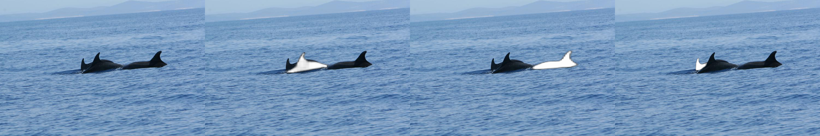

IOU metric for the input image is: 0.6188050720160738


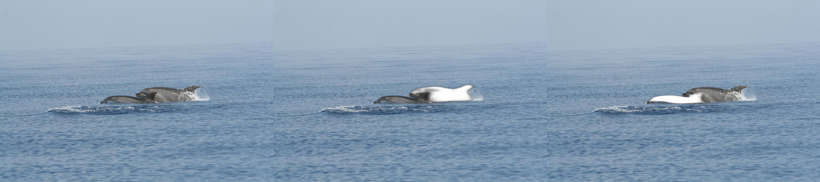

IOU metric for the input image is: 0.5790598755916212


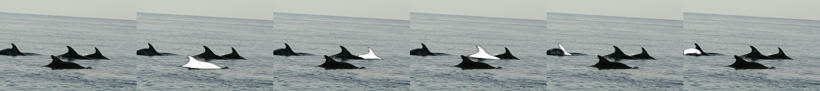

IOU metric for the input image is: 0.5138045344933209


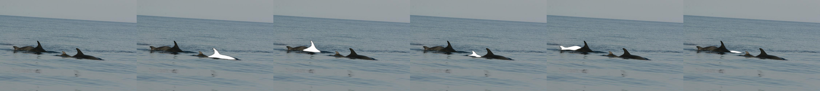

In [ ]:
from dolphins_recognition_challenge.instance_segmentation.model import show_prediction, iou_metric_example

for i in range(4):
    iou_test_image = iou_metric_example(model, data_loader_test.dataset[i], 0.5)
    img, _ = data_loader_test.dataset[i]
    print(f"IOU metric for the input image is: {iou_test_image}")
    show_prediction(model, img, width=820)


Calculate the mean IOU metric for the entire data set

In [ ]:
%%time

from dolphins_recognition_challenge.instance_segmentation.model import iou_metric, show_predictions_sorted_by_iou

mean_iou_testset, _ = iou_metric(model, data_loader_test.dataset)

print(f"Mean IOU metric for the test set is: {mean_iou_testset}")

Mean IOU metric for the test set is: 0.45871173589935726
CPU times: user 10.6 s, sys: 19.9 ms, total: 10.6 s
Wall time: 7.08 s


...

IOU metric: 0.23184597232650433


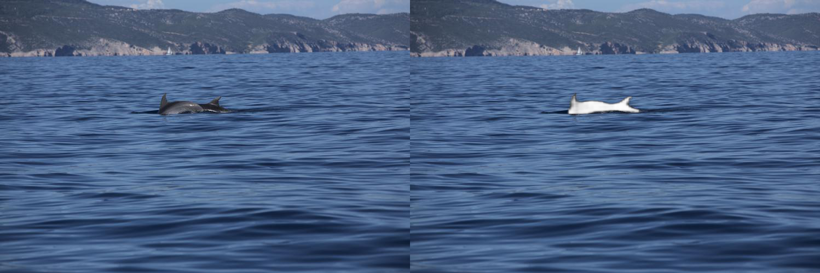

IOU metric: 0.24581407779447353


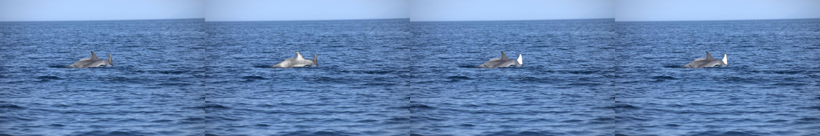

IOU metric: 0.24618816019374148


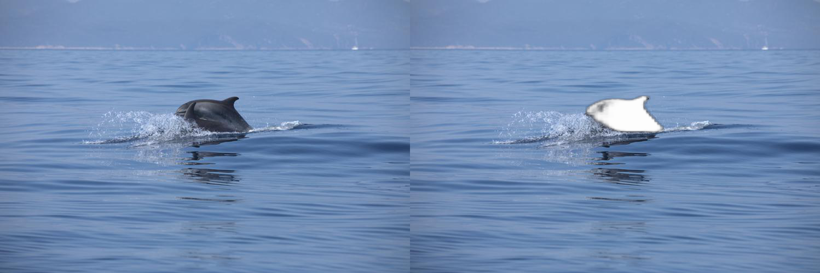

IOU metric: 0.2555991486030988


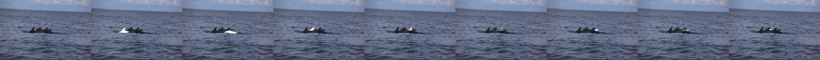

IOU metric: 0.3009551120616335


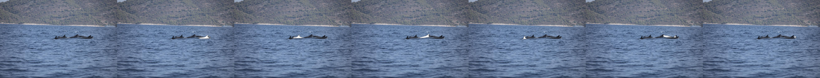

IOU metric: 0.30301062114673694


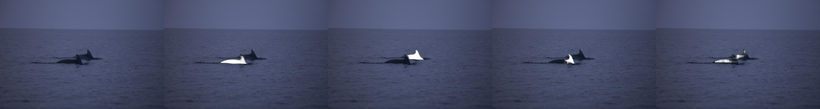

IOU metric: 0.31223090414023597


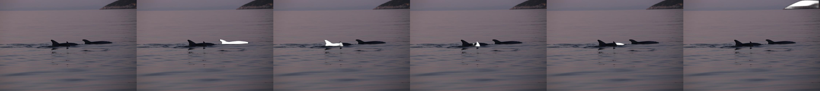

IOU metric: 0.32287201526036274


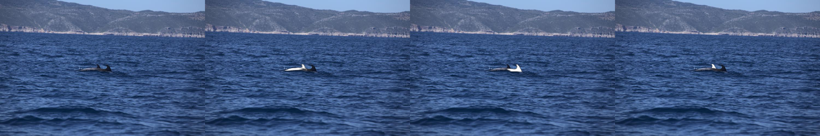

IOU metric: 0.35421019210181454


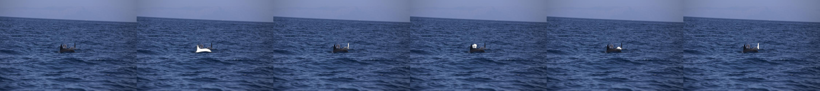

IOU metric: 0.3611191795266899


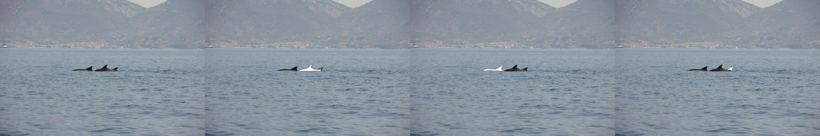

IOU metric: 0.3900684088378557


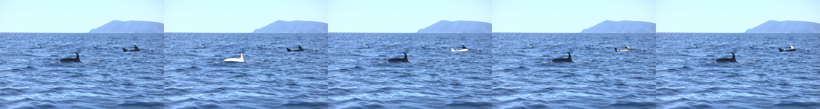

IOU metric: 0.3944734436506459


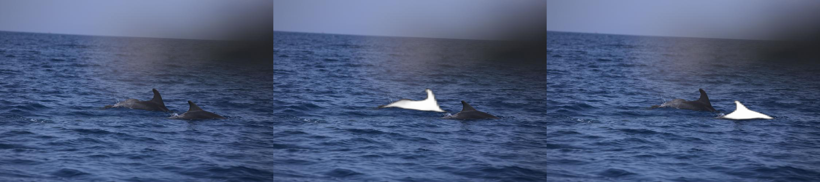

IOU metric: 0.39596665889815275


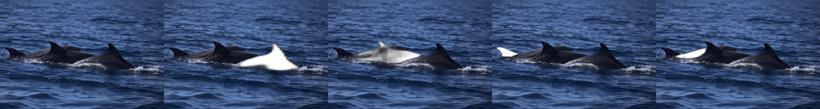

IOU metric: 0.4046655371894457


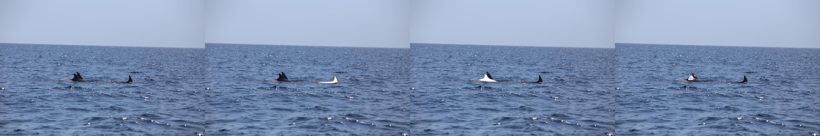

IOU metric: 0.40473742236010396


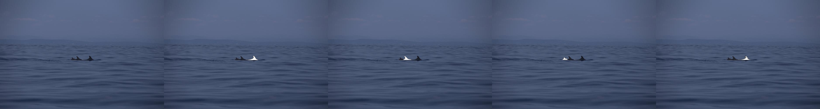

IOU metric: 0.4067293943715474


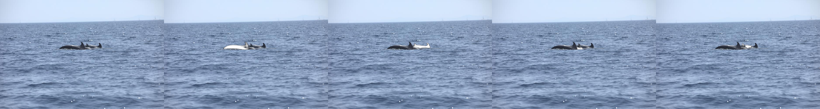

IOU metric: 0.4068489354652476


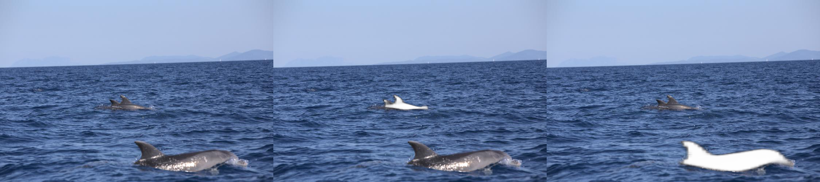

IOU metric: 0.40797115209198775


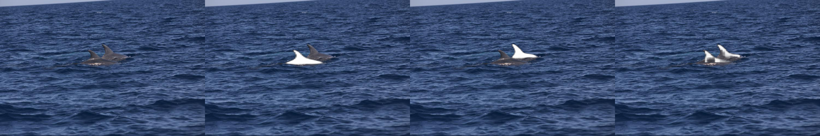

IOU metric: 0.4183618790635502


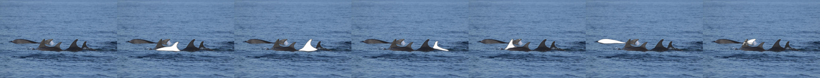

IOU metric: 0.4330426583394982


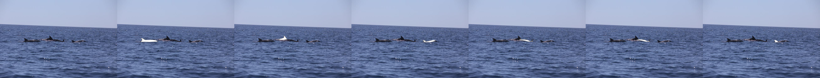

IOU metric: 0.43434213493463114


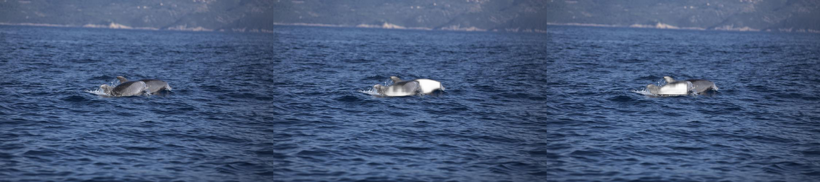

IOU metric: 0.4355279368169243


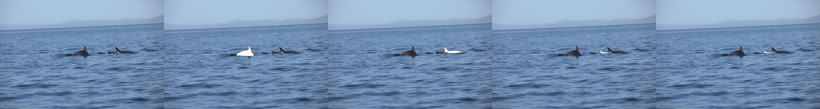

IOU metric: 0.4455225465549054


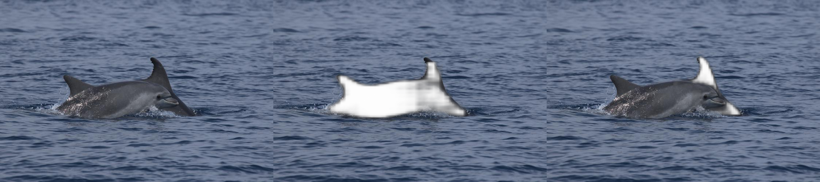

IOU metric: 0.48451056615999233


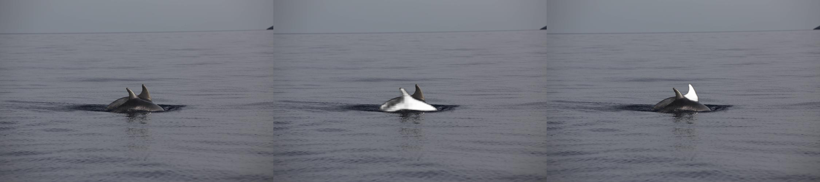

IOU metric: 0.5004015227947641


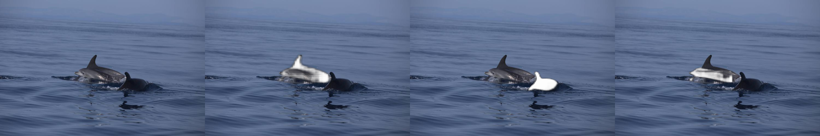

IOU metric: 0.512984890581837


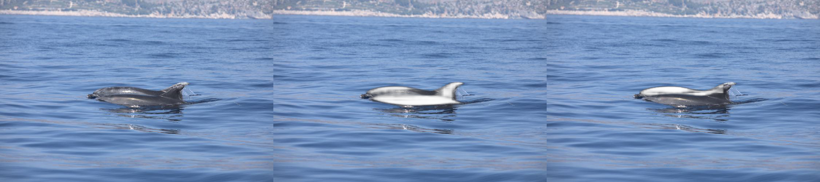

IOU metric: 0.5138045344933209


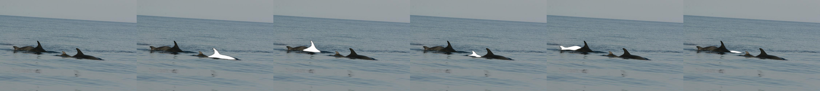

IOU metric: 0.5445646280196771


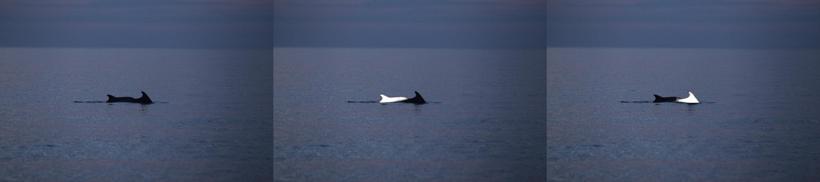

IOU metric: 0.5735681293787354


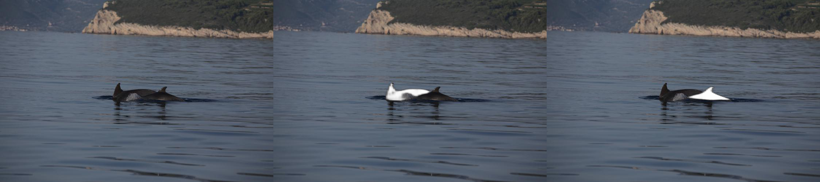

IOU metric: 0.5762955944824969


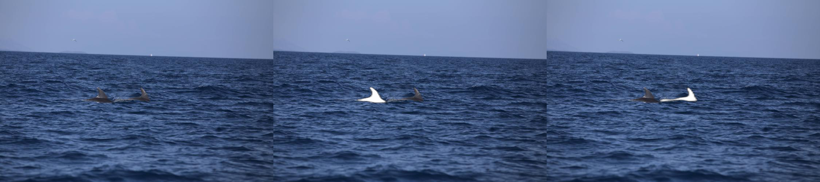

IOU metric: 0.5790598755916212


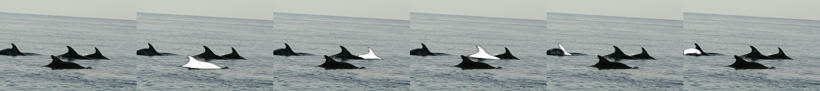

IOU metric: 0.6039832798984675


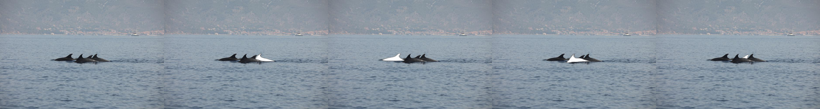

IOU metric: 0.6163980828568573


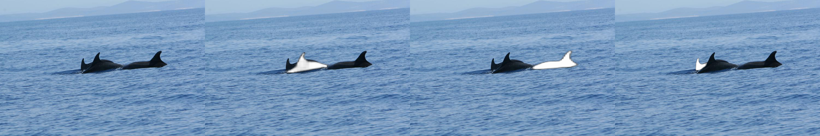

IOU metric: 0.6188050720160738


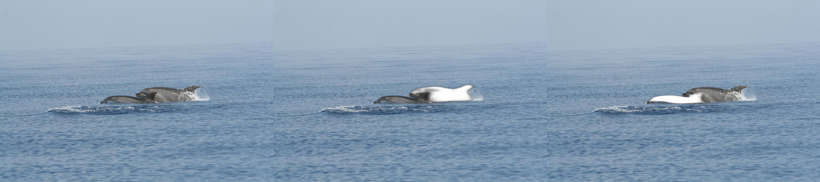

IOU metric: 0.6271841589218914


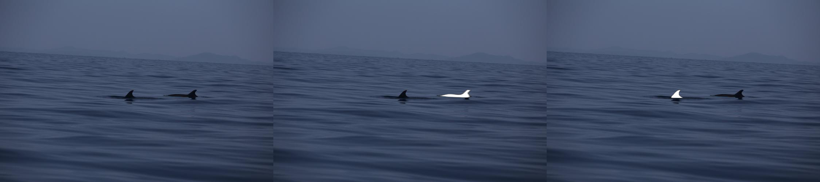

IOU metric: 0.6621209775426122


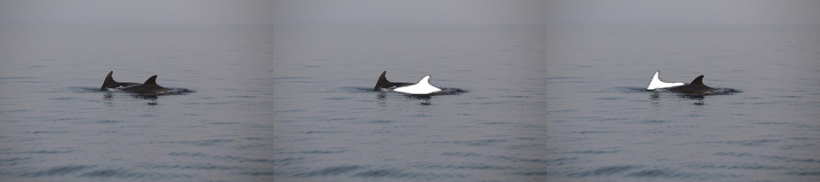

IOU metric: 0.6829042616073147


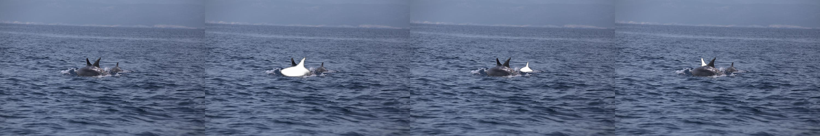

IOU metric: 0.6868579776768257


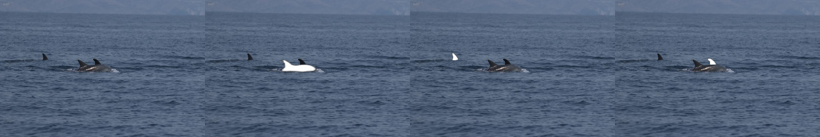

IOU metric: 0.7942106563226543


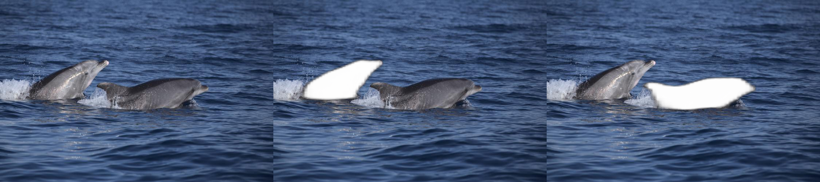

In [ ]:
show_predictions_sorted_by_iou(model, data_loader_test.dataset)

## Submit solution

Here we can see how to use the `submit_model` function. We must pass trained model, an alias that will be displayed on the leaderboard, name and email. Returns the path to the zipped file. 

In [ ]:
from dolphins_recognition_challenge.submissions import submit_model

zip_fname = submit_model(model, alias="dolphin123", name="Name Surname", email="name.surname@gmail.com")

Here we can check what is in the zip file. The zip file contains the model and 2 csv files. The first CSV file contains the iou metrics for each image from the validation set, and the second file contains information about the competitor.

In [ ]:
!unzip -vl "{zip_fname}"

Archive:  submission-iou=0.45871-dolphin123-name.surname@gmail.com-2021-01-05T12:40:05.356274.zip
 Length   Method    Size  Cmpr    Date    Time   CRC-32   Name
--------  ------  ------- ---- ---------- ----- --------  ----
    3358  Stored     3358   0% 2021-01-05 12:40 c2521ef8  submission-iou=0.45871-dolphin123-name.surname@gmail.com-2021-01-05T12:40:05.356274/metrics.csv
176247138  Stored 176247138   0% 2021-01-05 12:40 a3a38cbc  submission-iou=0.45871-dolphin123-name.surname@gmail.com-2021-01-05T12:40:05.356274/model.pt
      94  Stored       94   0% 2021-01-05 12:40 a9fa1065  submission-iou=0.45871-dolphin123-name.surname@gmail.com-2021-01-05T12:40:05.356274/info.csv
--------          -------  ---                            -------
176250590         176250590   0%                            3 files
